<a href="https://colab.research.google.com/github/Ibrahimsyah/Foories/blob/ml/notebooks/02_Model_Training_%26_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing datasets

In [ ]:
!pip install gdown -q

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pathlib
import numpy as np
import matplotlib.pylab as plt

In [ ]:
# dataset_v4

!gdown 'https://drive.google.com/uc?id=1-5Eosu193w4CfmCurC7Rj1obEk0lV-55' -O dataset_cleaned_v4.zip
!unzip -q dataset_cleaned_v4.zip
!mv /content/content/dataset /content
!rm -rf /content/content

Downloading...
From: https://drive.google.com/uc?id=1-5Eosu193w4CfmCurC7Rj1obEk0lV-55
To: /content/dataset_cleaned_v4.zip
150MB [00:01, 94.7MB/s]


In [ ]:
dataset_dir = "/content/dataset"
train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/dev"
test_dir = "/content/dataset/test"

In [ ]:
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


# Making ImageGenerator

In [ ]:
BATCH_SIZE = 64 #@param {type:"integer"}

In [ ]:
# Datagen
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen =  ImageDataGenerator(rescale=1./255)

# Flow training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

# Flow validation data generator
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

# Flow test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 10100 images belonging to 14 classes.
Found 1750 images belonging to 14 classes.
Found 1750 images belonging to 14 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())

# Create a labels.txt file with the class names

with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3,), 
    output_shape=[FV_SIZE],
    trainable=False
)

In [ ]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_12 (Dense)             (None, 64)                81984     
_________________________________________________________________
dense_13 (Dense)             (None, 14)                910       
Total params: 2,340,878
Trainable params: 82,894
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training using MobileNet v2

In [ ]:
from keras import callbacks

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=3,
    restore_best_weights=True
)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/10
158/158 [==============================] - 98s 614ms/step - loss: 1.0133 - accuracy: 0.6929 - val_loss: 0.6570 - val_accuracy: 0.7897
Epoch 2/10
158/158 [==============================] - 96s 607ms/step - loss: 0.5855 - accuracy: 0.8176 - val_loss: 0.5486 - val_accuracy: 0.8331
Epoch 3/10
158/158 [==============================] - 96s 607ms/step - loss: 0.5041 - accuracy: 0.8398 - val_loss: 0.5034 - val_accuracy: 0.8474
Epoch 4/10
158/158 [==============================] - 96s 606ms/step - loss: 0.4378 - accuracy: 0.8629 - val_loss: 0.5040 - val_accuracy: 0.8394
Epoch 5/10
158/158 [==============================] - 96s 606ms/step - loss: 0.4067 - accuracy: 0.8672 - val_loss: 0.5010 - val_accuracy: 0.8411
Epoch 6/10
158/158 [==============================] - 96s 606ms/step - loss: 0.3663 - accuracy: 0.8816 - val_loss: 0.5260 - val_accuracy: 0.8371
Epoch 7/10
158/158 [==============================] - 96s 605ms/step - loss: 0.3441 - accuracy: 0.8871 - val_loss: 0.5568 - val_ac

# Training results

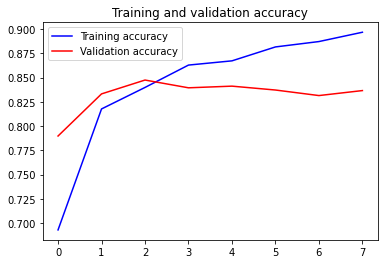

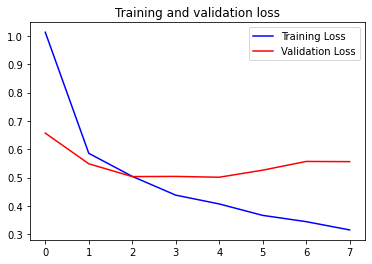

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate final score on Validation and Testing data

scores = model.evaluate(validation_generator)
scores = model.evaluate(test_generator)

28/28 [==============================] - 3s 113ms/step - loss: 0.4395 - accuracy: 0.8577


## Conclusion:

Transfer Learning Mobilenet_v2 with dataset_v4:

- Training: 86.72 %
- Validation: 84.11 %
- Testing: 85.77 %

Avoidable error might be improved.

# Exporting model

In [ ]:
model.save('model_v4.h5')
model.save('model_v4')
!zip -r 'model_v4.zip' 'model_v4'

INFO:tensorflow:Assets written to: model_v4/assets


INFO:tensorflow:Assets written to: model_v4/assets


  adding: model_v4/ (stored 0%)
  adding: model_v4/assets/ (stored 0%)
  adding: model_v4/keras_metadata.pb (deflated 84%)
  adding: model_v4/saved_model.pb (deflated 92%)
  adding: model_v4/variables/ (stored 0%)
  adding: model_v4/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_v4/variables/variables.index (deflated 78%)


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('model_v4')

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Invoke the converter to generate the TFLite model
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model_v4.tflite')
tflite_model_file.write_bytes(tflite_model)

2734128

# Model Evaluation and Metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

       bakso       0.68      0.86      0.76       125
     dessert       0.71      0.83      0.76       125
         egg       0.79      0.78      0.78       125
french_fries       0.96      0.84      0.90       125
  fried_rice       0.92      0.90      0.91       125
   hamburger       0.90      0.82      0.86       125
        meat       0.84      0.86      0.85       125
       pizza       0.91      0.93      0.92       125
        sate       0.86      0.92      0.89       125
        soto       0.84      0.74      0.79       125
        soup       0.95      0.88      0.91       125
   spaghetti       0.95      0.94      0.95       125
       sushi       0.84      0.78      0.81       125
    vegfruit       0.95      0.94      0.94       125

    accuracy                           0.86      1750
   macro avg       0.86      0.86      0.86      1750
weighted avg       0.86      0.86      0.86      1750



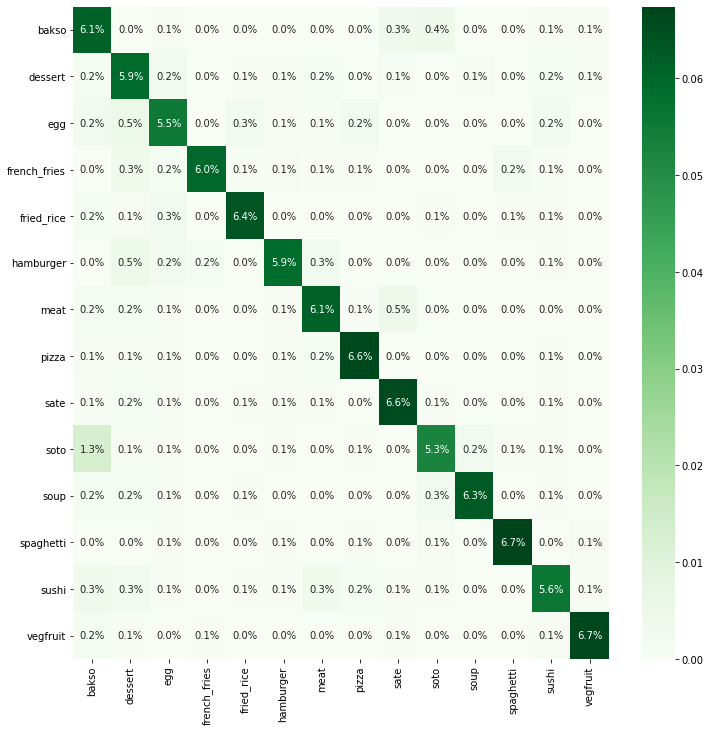

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,12))
ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap="Greens", xticklabels=class_names, yticklabels=class_names)

plt.show()

## Notes on improvement

- Soto and Bakso are similar in appearance. Might need to add diverse data for those two classes